# Customer Segmentation using Clustering
***
This mini-project is based on [this blog post](http://blog.yhat.com/posts/customer-segmentation-using-python.html) by yhat. Please feel free to refer to the post for additional information, and solutions.

In [1]:
%matplotlib inline
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

## Data

The dataset contains information on marketing newsletters/e-mail campaigns (e-mail offers sent to customers) and transaction level data from customers. The transactional data shows which offer customers responded to, and what the customer ended up buying. The data is presented as an Excel workbook containing two worksheets. Each worksheet contains a different dataset.

In [3]:
df_offers = pd.read_excel("./WineKMC.xlsx", sheetname=0)
df_offers.columns = ["offer_id", "campaign", "varietal", "min_qty", "discount", "origin", "past_peak"]
df_offers.head()

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
0,1,January,Malbec,72,56,France,False
1,2,January,Pinot Noir,72,17,France,False
2,3,February,Espumante,144,32,Oregon,True
3,4,February,Champagne,72,48,France,True
4,5,February,Cabernet Sauvignon,144,44,New Zealand,True


We see that the first dataset contains information about each offer such as the month it is in effect and several attributes about the wine that the offer refers to: the variety, minimum quantity, discount, country of origin and whether or not it is past peak. The second dataset in the second worksheet contains transactional data -- which offer each customer responded to.

In [4]:
df_transactions = pd.read_excel("./WineKMC.xlsx", sheetname=1)
df_transactions.columns = ["customer_name", "offer_id"]
df_transactions['n'] = 1
df_transactions.head()

,customer_name,offer_id,n
0,Smith,2,1
1,Smith,24,1
2,Johnson,17,1
3,Johnson,24,1
4,Johnson,26,1


## Data wrangling

We're trying to learn more about how our customers behave, so we can use their behavior (whether or not they purchased something based on an offer) as a way to group similar minded customers together. We can then study those groups to look for patterns and trends which can help us formulate future offers.

The first thing we need is a way to compare customers. To do this, we're going to create a matrix that contains each customer and a 0/1 indicator for whether or not they responded to a given offer. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set I</h3>

<p><b>Exercise:</b> Create a data frame where each row has the following columns (Use the pandas [`merge`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html) and [`pivot_table`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.pivot_table.html) functions for this purpose):
<ul>
<li> customer_name
<li> One column for each offer, with a 1 if the customer responded to the offer
</ul>
<p>Make sure you also deal with any weird values such as `NaN`. Read the documentation to develop your solution.</p>
</div>

In [607]:
#Create a data frame 
# Step 1 - merge the two data sets 
df_merged = pd.merge(df_offers,df_transactions, how = 'inner', on='offer_id')
df_merged.head()

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak,customer_name,n
0,1,January,Malbec,72,56,France,False,Thomas,1
1,1,January,Malbec,72,56,France,False,Jackson,1
2,1,January,Malbec,72,56,France,False,Mitchell,1
3,1,January,Malbec,72,56,France,False,Peterson,1
4,1,January,Malbec,72,56,France,False,Wood,1


In [608]:
# Step 2 - Use pivot to create a DF by customer name, offer and whether they responded to the offer or not.
df_pivot = pd.pivot_table(df_merged,values='n',columns='offer_id',index='customer_name',fill_value = 0)


## K-Means Clustering

Recall that in K-Means Clustering we want to *maximize* the distance between centroids and *minimize* the distance between data points and the respective centroid for the cluster they are in. True evaluation for unsupervised learning would require labeled data; however, we can use a variety of intuitive metrics to try to pick the number of clusters K. We will introduce two methods: the Elbow method, the Silhouette method and the gap statistic.

### Choosing K: The Elbow Sum-of-Squares Method

The first method looks at the sum-of-squares error in each cluster against $K$. We compute the distance from each data point to the center of the cluster (centroid) to which the data point was assigned. 

$$SS = \sum_k \sum_{x_i \in C_k} \sum_{x_j \in C_k} \left( x_i - x_j \right)^2 = \sum_k \sum_{x_i \in C_k} \left( x_i - \mu_k \right)^2$$

where $x_i$ is a point, $C_k$ represents cluster $k$ and $\mu_k$ is the centroid for cluster $k$. We can plot SS vs. $K$ and choose the *elbow point* in the plot as the best value for $K$. The elbow point is the point at which the plot starts descending much more slowly. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set II</h3>

<p><b>Exercise:</b></p> 
<ul>
<li> What values of $SS$ do you believe represent better clusterings? Why?
<li> Create a numpy matrix `x_cols` with only the columns representing the offers (i.e. the 0/1 colums) 
<li> Write code that applies the [`KMeans`](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) clustering method from scikit-learn to this matrix. 
<li> Construct a plot showing $SS$ for each $K$ and pick $K$ using this plot. For simplicity, test $2 \le K \le 10$.
<li> Make a bar chart showing the number of points in each cluster for k-means under the best $K$.
<li> What challenges did you experience using the Elbow method to pick $K$?
</ul>
</div>

### <i> What values of  SS  do you believe represent better clusterings? Why ? </i>

<b>Ans :</b> Sum of square is the distance between each data point and its centroid (center of the cluster). Hence I beleive this distance should be small as the point will be near the cluster center. hence we should choose smaller value of SS for better clustering. 


In [609]:
# Create a numpy matrix x_cols with only the columns representing the offers (i.e. the 0/1 colums)
import numpy as np
x_cols = np.array(df_pivot[:])
x_cols[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 0], dtype=int64)

In [610]:
#Write code that applies the KMeans clustering method from scikit-learn to this matrix.
from sklearn.cluster import KMeans
k_cluster = KMeans().fit(x_cols)
k_cluster

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=8, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

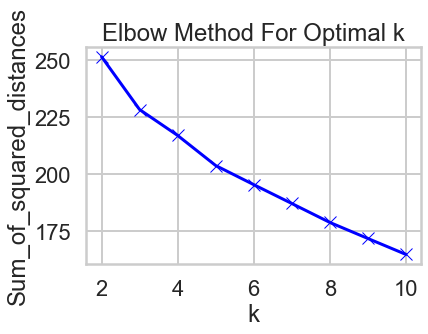

In [611]:
#Construct a plot showing SS for each K and pick K using this plot. For simplicity, test 2 <= K <= 10.
ss = []
K = range(2,11)
for k in K:
    k_model = KMeans(n_clusters=k,random_state=42)
    ss_temp = k_model.fit(x_cols)
    ss.append(ss_temp.inertia_)

plt.plot(K, ss, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [612]:
#Make a bar chart showing the number of points in each cluster for k-means under the best  K.
cluster = KMeans(n_clusters=3,random_state = 42)
df_pivot['cluster'] = cluster.fit_predict(x_cols)
df_pivot.head()

offer_id,1,2,3,4,5,6,7,8,9,10,...,24,25,26,27,28,29,30,31,32,cluster
customer_name,,,,,,,,,,,,,,,,,,,,,
Adams,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,1
Allen,0,0,0,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
Anderson,0,0,0,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,0,0,2
Bailey,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,1
Baker,0,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,1,0,0


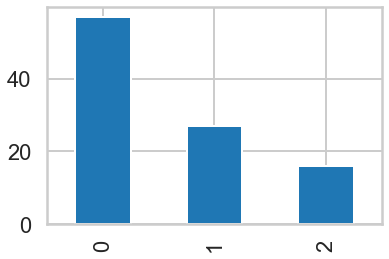

In [613]:
df_pivot.cluster.value_counts().plot(kind='bar')

### <i> What challenges did you experience using the Elbow method to pick  KK ? </i>

<b>Ans :</b> I could see two elbows. One at 3 clusters and other one near 5. I choose 3 as I felt the elbow was more steep at this point

### Choosing K: The Silhouette Method

There exists another method that measures how well each datapoint $x_i$ "fits" its assigned cluster *and also* how poorly it fits into other clusters. This is a different way of looking at the same objective. Denote $a_{x_i}$ as the *average* distance from $x_i$ to all other points within its own cluster $k$. The lower the value, the better. On the other hand $b_{x_i}$ is the minimum average distance from $x_i$ to points in a different cluster, minimized over clusters. That is, compute separately for each cluster the average distance from $x_i$ to the points within that cluster, and then take the minimum. The silhouette $s(x_i)$ is defined as

$$s(x_i) = \frac{b_{x_i} - a_{x_i}}{\max{\left( a_{x_i}, b_{x_i}\right)}}$$

The silhouette score is computed on *every datapoint in every cluster*. The silhouette score ranges from -1 (a poor clustering) to +1 (a very dense clustering) with 0 denoting the situation where clusters overlap. Some criteria for the silhouette coefficient is provided in the table below.

<pre>

| Range       | Interpretation                                |
|-------------|-----------------------------------------------|
| 0.71 - 1.0  | A strong structure has been found.            |
| 0.51 - 0.7  | A reasonable structure has been found.        |
| 0.26 - 0.5  | The structure is weak and could be artificial.|
| < 0.25      | No substantial structure has been found.      |

</pre>
Source: http://www.stat.berkeley.edu/~spector/s133/Clus.html

Fortunately, scikit-learn provides a function to compute this for us (phew!) called [`sklearn.metrics.silhouette_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html). Take a look at [this article](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html) on picking $K$ in scikit-learn, as it will help you in the next exercise set.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set III</h3>

<p><b>Exercise:</b> Using the documentation for the `silhouette_score` function above, construct a series of silhouette plots like the ones in the article linked above.</p>

<p><b>Exercise:</b> Compute the average silhouette score for each $K$ and plot it. What $K$ does the plot suggest we should choose? Does it differ from what we found using the Elbow method?</p>
</div>

For n_clusters = 2 The average silhouette_score is : 0.09174871508750351
For n_clusters = 3 The average silhouette_score is : 0.11542407037894219
For n_clusters = 4 The average silhouette_score is : 0.09670258360693122
For n_clusters = 5 The average silhouette_score is : 0.14531568820332333
For n_clusters = 6 The average silhouette_score is : 0.13313126627114877
For n_clusters = 7 The average silhouette_score is : 0.13073950771832585
For n_clusters = 8 The average silhouette_score is : 0.12397572901124844
For n_clusters = 9 The average silhouette_score is : 0.1202465110942483
For n_clusters = 10 The average silhouette_score is : 0.12695143123424532


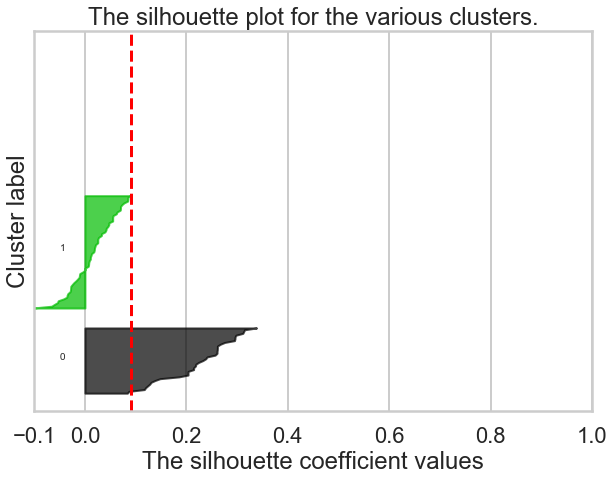

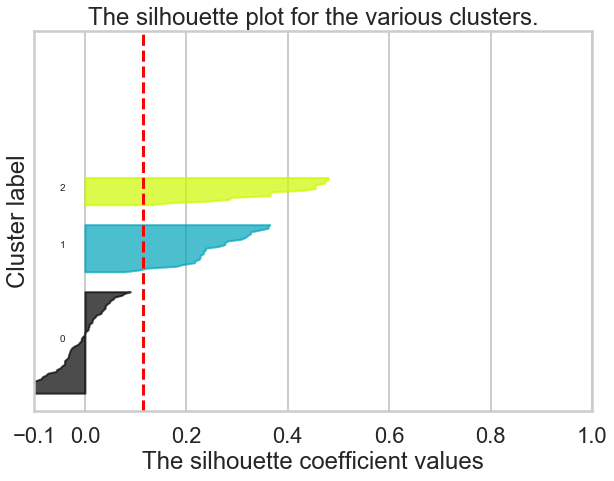

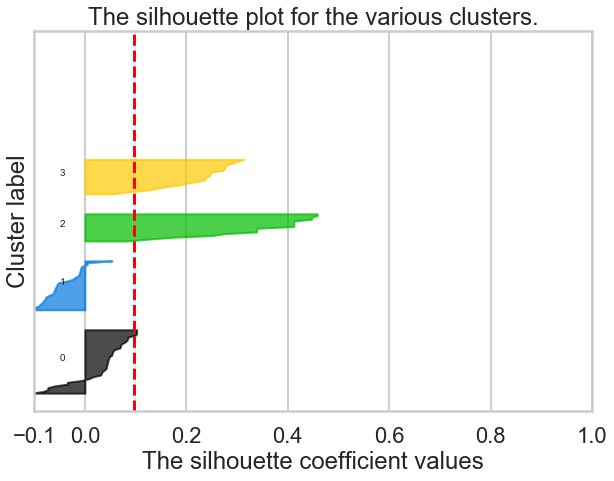

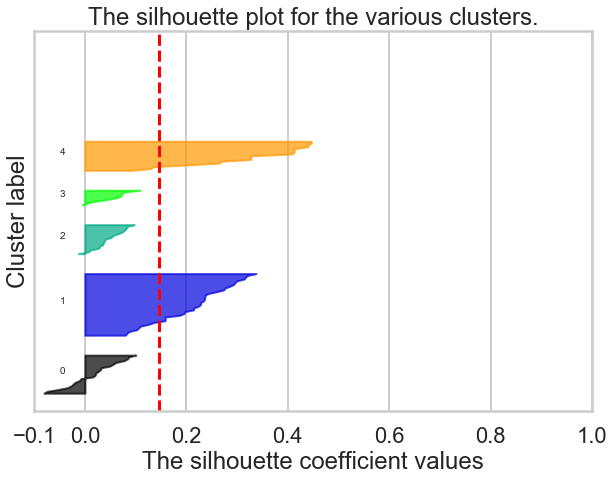

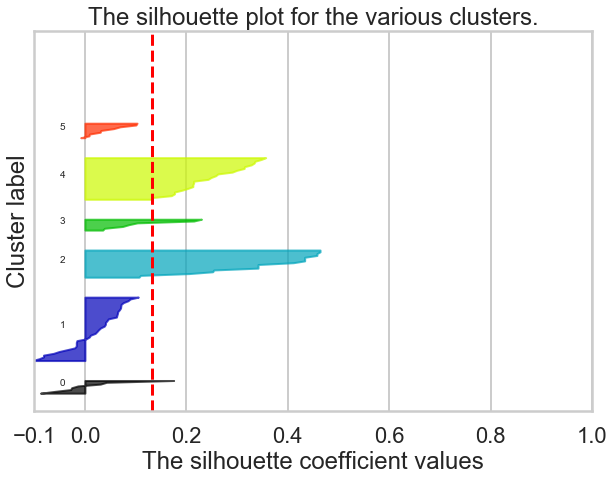

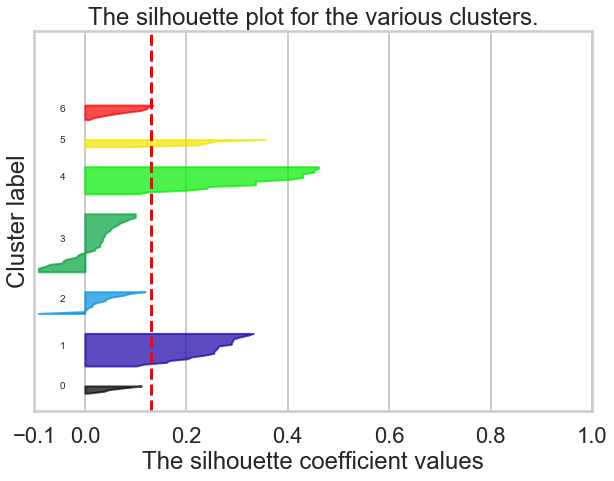

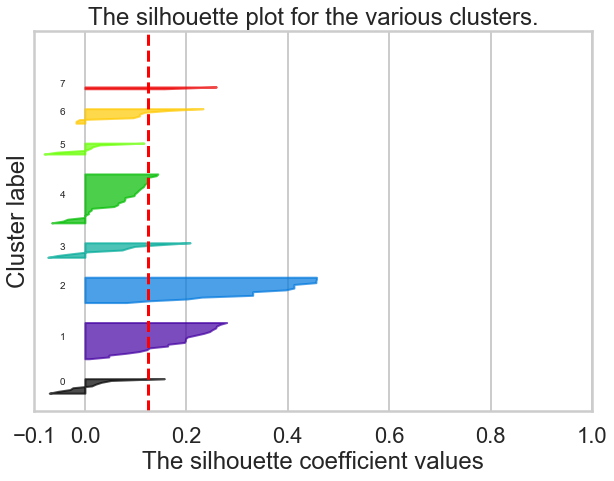

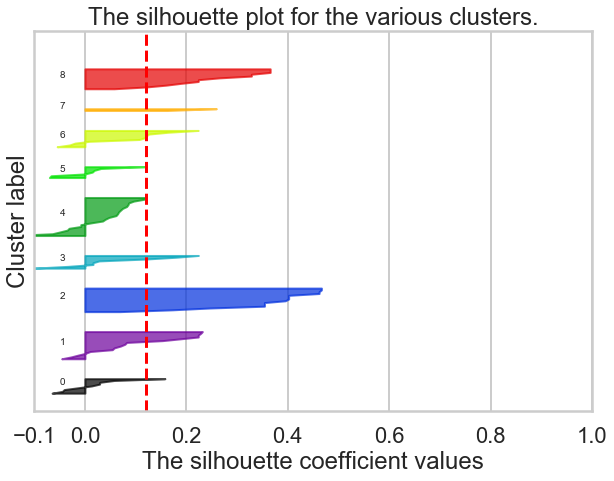

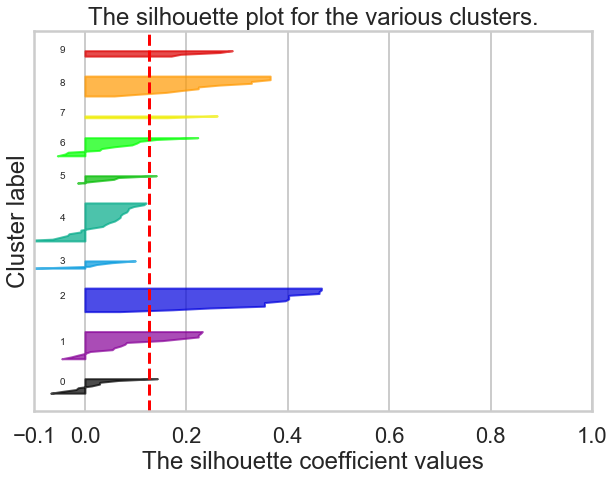

In [614]:
# Your turn.Using the documentation for the silhouette_score function above, construct a series of silhouette plots 
#like the ones in the article linked above.

from sklearn import metrics
import matplotlib.cm as cm

range_n_clusters = [2, 3, 4, 5, 6,7,8,9,10]
for n_clusters in range_n_clusters:
    
    # Create a subplot with 1 row and 1 columns
    fig,(ax1) = plt.subplots(1,1)
    fig.set_size_inches(10,7)
    
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1,1])
    ax1.set_ylim([0,len(x_cols) + (k + 1) *10])
    
    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 42 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters,random_state=42)
    clusterer_labels = clusterer.fit_predict(x_cols)
    sil_avg = metrics.silhouette_score(x_cols,clusterer_labels)    
    print("For n_clusters =", n_clusters,"The average silhouette_score is :", sil_avg)
    
    #Compute the silhouette scores for each sample
    sample_sil_values = metrics.silhouette_samples(x_cols,clusterer_labels)
    
    y_lower =10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_sil_values[clusterer_labels == i]
        ith_cluster_silhouette_values.sort()
        
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples
    
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    
    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=sil_avg, color="red", linestyle="--")
    
    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    
    
plt.show()

### Compute the average silhouette score for each  K  and plot it. What  K  does the plot suggest we should choose? Does it differ from what we found using the Elbow method?

<b>Ans :</b> To be frank it is very difficult to find the K based on above plot and all values are less that 0.25 which indicates no sunstantial structure. But K = 3 seems to be better as the score is second best and variance of data is not too fluctuating compared to others.

### Choosing $K$: The Gap Statistic

There is one last method worth covering for picking $K$, the so-called Gap statistic. The computation for the gap statistic builds on the sum-of-squares established in the Elbow method discussion, and compares it to the sum-of-squares of a "null distribution," that is, a random set of points with no clustering. The estimate for the optimal number of clusters $K$ is the value for which $\log{SS}$ falls the farthest below that of the reference distribution:

$$G_k = E_n^*\{\log SS_k\} - \log SS_k$$

In other words a good clustering yields a much larger difference between the reference distribution and the clustered data. The reference distribution is a Monte Carlo (randomization) procedure that constructs $B$ random distributions of points within the bounding box (limits) of the original data and then applies K-means to this synthetic distribution of data points.. $E_n^*\{\log SS_k\}$ is just the average $SS_k$ over all $B$ replicates. We then compute the standard deviation $\sigma_{SS}$ of the values of $SS_k$ computed from the $B$ replicates of the reference distribution and compute

$$s_k = \sqrt{1+1/B}\sigma_{SS}$$

Finally, we choose $K=k$ such that $G_k \geq G_{k+1} - s_{k+1}$.

### Aside: Choosing $K$ when we Have Labels

Unsupervised learning expects that we do not have the labels. In some situations, we may wish to cluster data that is labeled. Computing the optimal number of clusters is much easier if we have access to labels. There are several methods available. We will not go into the math or details since it is rare to have access to the labels, but we provide the names and references of these measures.

* Adjusted Rand Index
* Mutual Information
* V-Measure
* Fowlkes–Mallows index

See [this article](http://scikit-learn.org/stable/modules/clustering.html) for more information about these metrics.

## Visualizing Clusters using PCA

How do we visualize clusters? If we only had two features, we could likely plot the data as is. But we have 100 data points each containing 32 features (dimensions). Principal Component Analysis (PCA) will help us reduce the dimensionality of our data from 32 to something lower. For a visualization on the coordinate plane, we will use 2 dimensions. In this exercise, we're going to use it to transform our multi-dimensional dataset into a 2 dimensional dataset.

This is only one use of PCA for dimension reduction. We can also use PCA when we want to perform regression but we have a set of highly correlated variables. PCA untangles these correlations into a smaller number of features/predictors all of which are orthogonal (not correlated). PCA is also used to reduce a large set of variables into a much smaller one.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set IV</h3>

<p><b>Exercise:</b> Use PCA to plot your clusters:</p>

<ul>
<li> Use scikit-learn's [`PCA`](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) function to reduce the dimensionality of your clustering data to 2 components
<li> Create a data frame with the following fields:
  <ul>
  <li> customer name
  <li> cluster id the customer belongs to
  <li> the two PCA components (label them `x` and `y`)
  </ul>
<li> Plot a scatterplot of the `x` vs `y` columns
<li> Color-code points differently based on cluster ID
<li> How do the clusters look? 
<li> Based on what you see, what seems to be the best value for $K$? Moreover, which method of choosing $K$ seems to have produced the optimal result visually?
</ul>

<p><b>Exercise:</b> Now look at both the original raw data about the offers and transactions and look at the fitted clusters. Tell a story about the clusters in context of the original data. For example, do the clusters correspond to wine variants or something else interesting?</p>
</div>

In [620]:
#df_merged.head()

In [621]:
#df_pivot.head()

In [622]:
#x_cols[0]

In [618]:
df_pivot = df_pivot.reset_index()

In [619]:
#Use scikit-learn's PCA function to reduce the dimensionality of your clustering data to 2 components
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
pca.fit(x_cols)
reduced_data = pca.transform(x_cols)
reduced_data = pd.DataFrame(reduced_data, columns = ['x', 'y'])

#Create a dataframe with customer name, cluster_id and x and y dimensions
reduced_data['customer_name'] = df_pivot.customer_name
reduced_data['customer_cluster'] = df_pivot['cluster']

In [623]:
reduced_data.head()

,x,y,customer_name,customer_cluster
0,1.007580,0.108215,Adams,1
1,-0.287539,0.044715,Allen,0
2,-0.392032,1.038391,Anderson,2
3,0.699477,-0.022542,Bailey,1
4,0.088183,-0.471695,Baker,0


In [624]:
#centers = cluster.cluster_centers_
#centers

In [625]:
# find the cluster centers and transform to 2 dimensions
cluster_centers = pca.transform(cluster.cluster_centers_)
cluster_centers = pd.DataFrame(cluster_centers,columns=['x','y'])
cluster_centers

,x,y
0,-0.299291,-0.289337
1,0.877381,0.017672
2,-0.414356,1.000940


Text(0.5, 0.98, 'Silhouette analysis for KMeans clustering on sample data with n_clusters = 3')

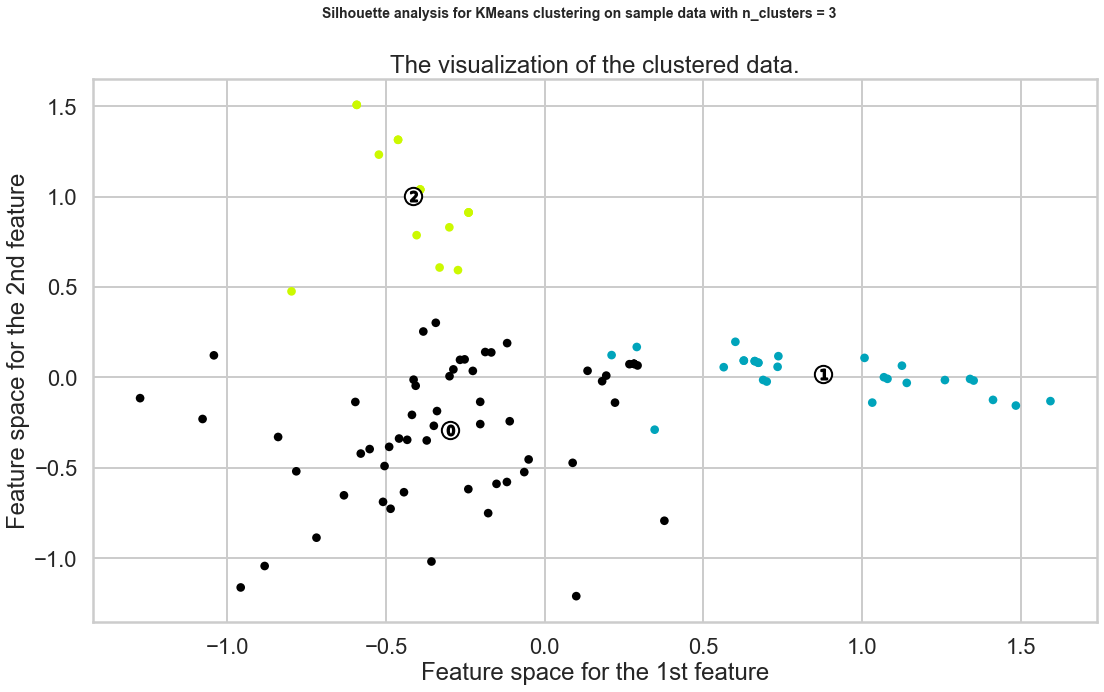

In [626]:
    
# Visualize the clusters
n_clusters = 3

fig,(ax1) = plt.subplots(1,1)
fig.set_size_inches(18,10)

colors = cm.nipy_spectral(reduced_data.customer_cluster.astype(float) / n_clusters)

ax1.scatter(reduced_data.x, reduced_data.y, marker='.', lw=0,s=300, alpha=1,
                c=colors, edgecolor='k')
    

cluster_centers = pca.transform(cluster.cluster_centers_)

ax1.scatter(cluster_centers[:, 0],cluster_centers[:, 1],marker='o',
#ax1.scatter(reduced_data.x, reduced_data.y,marker='o',
            c="white", alpha=1,s=300, edgecolor='k')
    
for i, c in enumerate(cluster_centers):
        ax1.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,s=100, edgecolor='k')
    
ax1.set_title("The visualization of the clustered data.")
ax1.set_xlabel("Feature space for the 1st feature")
ax1.set_ylabel("Feature space for the 2nd feature")

plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
              "with n_clusters = %d" % n_clusters),
                fontsize=14, fontweight='bold')

What we've done is we've taken those columns of 0/1 indicator variables, and we've transformed them into a 2-D dataset. We took one column and arbitrarily called it `x` and then called the other `y`. Now we can throw each point into a scatterplot. We color coded each point based on it's cluster so it's easier to see them.

### <i> How do the clusters look? Based on what you see, what seems to be the best value for  K ? Moreover, which method of choosing  K  seems to have produced the optimal result visually? </i>

<b>Ans :</b> I tried with both 3 and 5 number of clusters. I felt 3 clusters seems to be the best value to seperate the data

### Now look at both the original raw data about the offers and transactions and look at the fitted clusters. Tell a story about the clusters in context of the original data. For example, do the clusters correspond to wine variants or something else interesting?

In [627]:
# merging all data and checking out few rows
df = pd.merge(df_transactions,reduced_data)
df = pd.merge(df_offers,df,)
df.head(10)

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak,customer_name,n,x,y,customer_cluster
0,1,January,Malbec,72,56,France,False,Thomas,1,-1.041879,0.122314,0
1,1,January,Malbec,72,56,France,False,Jackson,1,-0.839578,-0.328823,0
2,1,January,Malbec,72,56,France,False,Mitchell,1,-0.342938,0.302186,0
3,1,January,Malbec,72,56,France,False,Peterson,1,-0.797379,0.475995,2
4,1,January,Malbec,72,56,France,False,Wood,1,-0.551215,-0.395670,0
5,1,January,Malbec,72,56,France,False,Price,1,-0.177934,-0.749716,0
6,1,January,Malbec,72,56,France,False,Foster,1,-0.782355,-0.518475,0
7,1,January,Malbec,72,56,France,False,Sanders,1,-1.274329,-0.114296,0
8,1,January,Malbec,72,56,France,False,Butler,1,-0.240431,-0.617026,0
9,1,January,Malbec,72,56,France,False,Fisher,1,-0.509137,-0.687321,0


### Lets look at  which variety of wine is most or least popular among each cluster

In [628]:
# Cluser 0 - Observations
# a) They seem to like Champagne a lot(79 vs 1), followed by cabernet (31 vs 1)
# b) They do not seem to like Pinot Noir (37 vs 7) and Pinot Grigio (16 vs 1)

df['is_0'] = df.customer_cluster==0
df.groupby('is_0').varietal.value_counts()

is_0   varietal          
False  Pinot Noir            37
       Espumante             25
       Malbec                17
       Pinot Grigio          16
       Prosecco              16
       Merlot                 7
       Champagne              2
       Cabernet Sauvignon     1
       Chardonnay             1
True   Champagne             79
       Cabernet Sauvignon    31
       Prosecco              27
       Espumante             15
       Malbec                15
       Chardonnay            14
       Merlot                13
       Pinot Noir             7
       Pinot Grigio           1
Name: varietal, dtype: int64

In [629]:
# Cluser 1 - Observations
# a) They seem to like Pinot Grigio (16 vs 1)
# b) They do not seem to like Champagne (80 vs 1), Pinot Nior, Cabernet (31 vs 1)
# c) They seem neutral towards Malbec (16 vs 16) and Espumate (25 vs 15)

df['is_1'] = df.customer_cluster==1
df.groupby('is_1').varietal.value_counts()

is_1   varietal          
False  Champagne             80
       Pinot Noir            44
       Cabernet Sauvignon    31
       Prosecco              29
       Malbec                16
       Chardonnay            15
       Espumante             15
       Merlot                14
       Pinot Grigio           1
True   Espumante             25
       Malbec                16
       Pinot Grigio          16
       Prosecco              14
       Merlot                 6
       Cabernet Sauvignon     1
       Champagne              1
Name: varietal, dtype: int64

In [630]:
# Cluser 2 - Observations
# a) They seem to like Pinot Noir (37 vs 7). Infact it is the only wine they have high liking for.
# b) They do not seem to like Champagne (80 vs 1), Prosecco(41 vs 2), Espumate etc
# c) They seem neutral towards Malbec (16 vs 16) and Espumate (25 vs 15)

df['is_2'] = df.customer_cluster==2
df.groupby('is_2').varietal.value_counts()

is_2   varietal          
False  Champagne             80
       Prosecco              41
       Espumante             40
       Cabernet Sauvignon    32
       Malbec                31
       Merlot                19
       Pinot Grigio          17
       Chardonnay            14
       Pinot Noir             7
True   Pinot Noir            37
       Prosecco               2
       Champagne              1
       Chardonnay             1
       Malbec                 1
       Merlot                 1
Name: varietal, dtype: int64

### Let us see if if people in this cluster are bulk buyers. For this we check out minimum quantity and take a mean of it.

In [634]:
# Cluster 0 - Observations
# Looks like they are bulk buyers. Mean off minimum quantity bought is  76 KG.
# Also looking at the mean discount %, looks lke they have received close to 62% in discount.

df.groupby('is_0')[['min_qty','discount']].mean()

,min_qty,discount
is_0,,
False,28.770492,54.663934
True,76.306931,62.391089


In [635]:
# Cluster 1 - Observations
# Looks like they are not bulk buyers. Mean off minimum quantity bought is  8 KG.
# Also looking at the mean discount %, looks lke they have received close to 56% in discount which is not bad.

df.groupby('is_1')[['min_qty','discount']].mean()

,min_qty,discount
is_1,,
False,74.424490,60.587755
True,8.734177,56.050633


In [636]:
# Cluster 2 - Observations
# Looks like they are bulk buyers. Mean off minimum quantity bought is  65 KG. But compred to cluster 0, they are less
# Also looking at the mean discount %, looks like they have received close to 52% in discount which is less compared.

df.groupby('is_2')[['min_qty','discount']].mean()

,min_qty,discount
is_2,,
False,57.309609,60.608541
True,65.581395,52.116279


### Lets take a look at which months were popular in terms of buying per cluster

In [643]:
# Cluster 0 - Observation
# Looks like they are consistent buyers in almost all months except July, November and September

df.groupby('is_0').campaign.value_counts()

is_0   campaign 
False  March        25
       July         20
       November     17
       December     16
       October      13
       September    13
       January       7
       May           7
       April         2
       August        1
       June          1
True   August       30
       December     27
       March        26
       February     22
       June         19
       May          17
       October      17
       April        15
       January      13
       July          6
       November      6
       September     4
Name: campaign, dtype: int64

In [644]:
# Cluster 1 - Observation
# Looks like they are not that consistent. They have bought only 6 out of 12 months and that too May, April and
# August have been weak.

df.groupby('is_1').campaign.value_counts()

is_1   campaign 
False  August       30
       October      30
       December     27
       March        26
       February     22
       January      20
       June         20
       May          18
       September    17
       April        16
       July         13
       November      6
True   March        25
       November     17
       December     16
       July         13
       May           6
       April         1
       August        1
Name: campaign, dtype: int64

In [645]:
# Cluster 2 - Observation
# Looks like they are not that consistent. They have bought only 7 out of 12 months and that too June, April and
# May have been weak.

df.groupby('is_2').campaign.value_counts()

is_2   campaign 
False  March        51
       December     43
       August       31
       May          23
       November     23
       February     22
       July         19
       June         19
       October      17
       April        16
       January      13
       September     4
True   October      13
       September    13
       January       7
       July          7
       April         1
       June          1
       May           1
Name: campaign, dtype: int64

<div class="span5 alert alert-info">
<h3>Exercise Set V</h3>

<p>As we saw earlier, PCA has a lot of other uses. Since we wanted to visualize our data in 2 dimensions, restricted the number of dimensions to 2 in PCA. But what is the true optimal number of dimensions?</p>

<p><b>Exercise:</b> Using a new PCA object shown in the next cell, plot the `explained_variance_` field and look for the elbow point, the point where the curve's rate of descent seems to slow sharply. This value is one possible value for the optimal number of dimensions. What is it?</p>
<p><b>Ans :</b> 2 number of dimensions hardly is able to explain 20 % of variance. First 10 of the components are ale to explain 70% of the variance. Looks like we need 10 to 15 components to explain majority of the variance.</p>
</div>

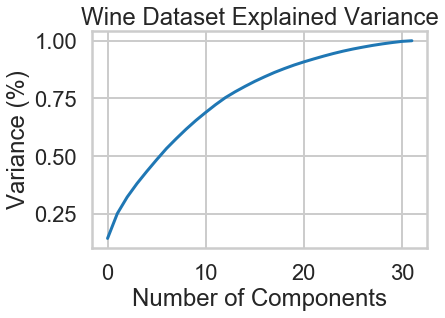

In [34]:
# Initialize a new PCA model with a default number of components.
import sklearn.decomposition
pca = sklearn.decomposition.PCA()
pca.fit(x_cols)

# Do the rest on your own :)
#Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Wine Dataset Explained Variance')
plt.show()



## Other Clustering Algorithms

k-means is only one of a ton of clustering algorithms. Below is a brief description of several clustering algorithms, and the table provides references to the other clustering algorithms in scikit-learn. 

* **Affinity Propagation** does not require the number of clusters $K$ to be known in advance! AP uses a "message passing" paradigm to cluster points based on their similarity. 

* **Spectral Clustering** uses the eigenvalues of a similarity matrix to reduce the dimensionality of the data before clustering in a lower dimensional space. This is tangentially similar to what we did to visualize k-means clusters using PCA. The number of clusters must be known a priori.

* **Ward's Method** applies to hierarchical clustering. Hierarchical clustering algorithms take a set of data and successively divide the observations into more and more clusters at each layer of the hierarchy. Ward's method is used to determine when two clusters in the hierarchy should be combined into one. It is basically an extension of hierarchical clustering. Hierarchical clustering is *divisive*, that is, all observations are part of the same cluster at first, and at each successive iteration, the clusters are made smaller and smaller. With hierarchical clustering, a hierarchy is constructed, and there is not really the concept of "number of clusters." The number of clusters simply determines how low or how high in the hierarchy we reference and can be determined empirically or by looking at the [dendogram](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html).

* **Agglomerative Clustering** is similar to hierarchical clustering but but is not divisive, it is *agglomerative*. That is, every observation is placed into its own cluster and at each iteration or level or the hierarchy, observations are merged into fewer and fewer clusters until convergence. Similar to hierarchical clustering, the constructed hierarchy contains all possible numbers of clusters and it is up to the analyst to pick the number by reviewing statistics or the dendogram.

* **DBSCAN** is based on point density rather than distance. It groups together points with many nearby neighbors. DBSCAN is one of the most cited algorithms in the literature. It does not require knowing the number of clusters a priori, but does require specifying the neighborhood size.

### Clustering Algorithms in Scikit-learn
<table border="1">
<colgroup>
<col width="15%" />
<col width="16%" />
<col width="20%" />
<col width="27%" />
<col width="22%" />
</colgroup>
<thead valign="bottom">
<tr><th>Method name</th>
<th>Parameters</th>
<th>Scalability</th>
<th>Use Case</th>
<th>Geometry (metric used)</th>
</tr>
</thead>
<tbody valign="top">
<tr><td>K-Means</span></a></td>
<td>number of clusters</td>
<td>Very large<span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span> with
MiniBatch code</td>
<td>General-purpose, even cluster size, flat geometry, not too many clusters</td>
<td>Distances between points</td>
</tr>
<tr><td>Affinity propagation</td>
<td>damping, sample preference</td>
<td>Not scalable with n_samples</td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Mean-shift</td>
<td>bandwidth</td>
<td>Not scalable with <span class="pre">n_samples</span></td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Distances between points</td>
</tr>
<tr><td>Spectral clustering</td>
<td>number of clusters</td>
<td>Medium <span class="pre">n_samples</span>, small <span class="pre">n_clusters</span></td>
<td>Few clusters, even cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Ward hierarchical clustering</td>
<td>number of clusters</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints</td>
<td>Distances between points</td>
</tr>
<tr><td>Agglomerative clustering</td>
<td>number of clusters, linkage type, distance</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints, non Euclidean
distances</td>
<td>Any pairwise distance</td>
</tr>
<tr><td>DBSCAN</td>
<td>neighborhood size</td>
<td>Very large <span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span></td>
<td>Non-flat geometry, uneven cluster sizes</td>
<td>Distances between nearest points</td>
</tr>
<tr><td>Gaussian mixtures</td>
<td>many</td>
<td>Not scalable</td>
<td>Flat geometry, good for density estimation</td>
<td>Mahalanobis distances to  centers</td>
</tr>
<tr><td>Birch</td>
<td>branching factor, threshold, optional global clusterer.</td>
<td>Large <span class="pre">n_clusters</span> and <span class="pre">n_samples</span></td>
<td>Large dataset, outlier removal, data reduction.</td>
<td>Euclidean distance between points</td>
</tr>
</tbody>
</table>
Source: http://scikit-learn.org/stable/modules/clustering.html

<div class="span5 alert alert-info">
<h3>Exercise Set VI</h3>

<p><b>Exercise:</b> Try clustering using the following algorithms. </p>
<ol>
<li>Affinity propagation
<li>Spectral clustering
<li>Agglomerative clustering
<li>DBSCAN
</ol>
<p>How do their results compare? Which performs the best? Tell a story why you think it performs the best.</p>
</div>


## Affinity propagation

In [671]:
from sklearn.cluster import AffinityPropagation
clustering_ap = AffinityPropagation(preference=-34).fit(x_cols)
clustering_ap.labels_

array([1, 2, 0, 1, 2, 2, 0, 1, 2, 1, 1, 0, 1, 2, 1, 0, 2, 0, 1, 2, 1, 2,
       2, 2, 0, 2, 2, 2, 2, 0, 2, 2, 2, 2, 1, 1, 2, 1, 2, 1, 0, 0, 2, 2,
       1, 2, 1, 2, 2, 2, 2, 2, 2, 0, 2, 1, 0, 2, 1, 2, 2, 2, 2, 1, 1, 0,
       0, 2, 2, 2, 2, 2, 2, 2, 2, 1, 0, 2, 2, 0, 0, 0, 2, 0, 1, 2, 1, 0,
       1, 2, 2, 1, 2, 1, 1, 2, 1, 2, 2, 2], dtype=int64)

In [672]:
cluster_center_indices = clustering_ap.cluster_centers_indices_
n_clusters_ap = len(cluster_center_indices)
print('Estimated number of clusters: %d' % n_clusters_ap)

Estimated number of clusters: 3


In [673]:
labels_ap = clustering_ap.labels_
sil_coeff_ap = metrics.silhouette_score(x_cols,labels_ap,metric='euclidean')
print("Silhouette Coefficient: %0.3f"
      % sil_coeff_ap)

Silhouette Coefficient: 0.116


In [650]:
df_pivot_ap = df_pivot.drop('cluster',axis=1)
df_pivot_ap['cluster'] = clustering_ap.labels_
df_pivot_ap.head()

offer_id,customer_name,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,cluster
0,Adams,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,1
1,Allen,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,2
2,Anderson,0,0,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,0,0,0
3,Bailey,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,1
4,Baker,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,2


In [651]:
reduced_data_ap = reduced_data.drop('customer_cluster',axis=1)
reduced_data_ap['customer_cluster'] = df_pivot_ap['cluster']
reduced_data_ap.head()

,x,y,customer_name,customer_cluster
0,1.007580,0.108215,Adams,1
1,-0.287539,0.044715,Allen,2
2,-0.392032,1.038391,Anderson,0
3,0.699477,-0.022542,Bailey,1
4,0.088183,-0.471695,Baker,2


Text(0.5, 0.98, 'Silhouette analysis for Affinity propagation clustering on sample data with n_clusters = 3')

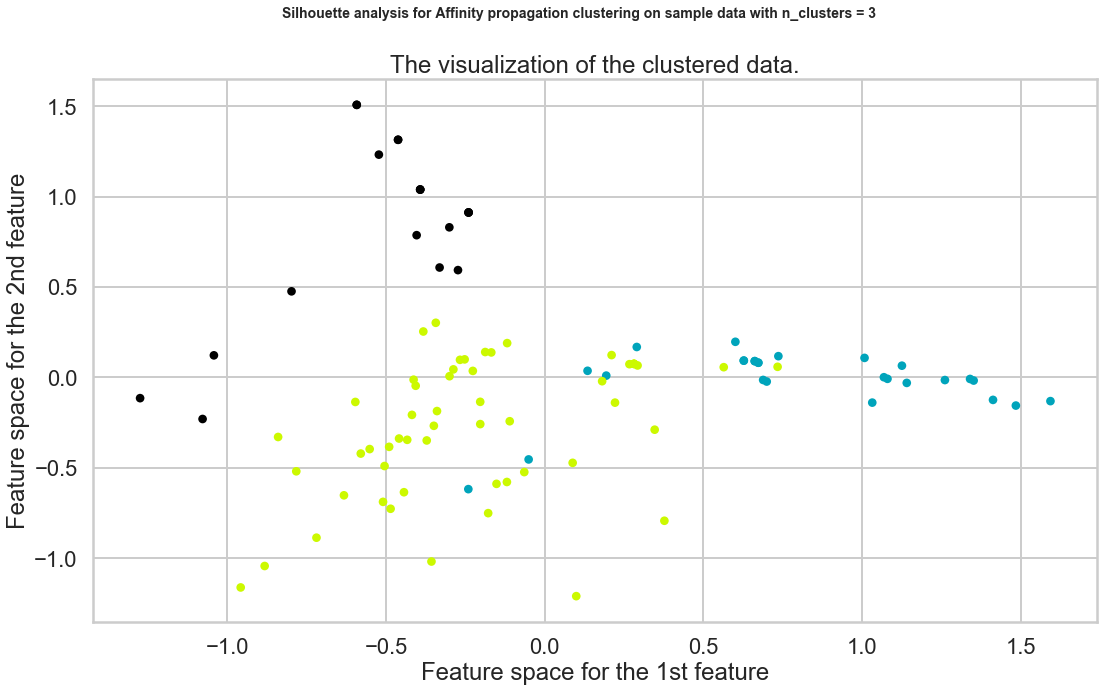

In [734]:
n_clusters = 3

fig,(ax1) = plt.subplots(1,1)
fig.set_size_inches(18,10)

colors = cm.nipy_spectral(reduced_data_ap.customer_cluster.astype(float) / n_clusters)

ax1.scatter(reduced_data_ap.x, reduced_data_ap.y, marker='.', lw=0,s=300, alpha=1,
                c=colors, edgecolor='k')
    

  
ax1.set_title("The visualization of the clustered data.")
ax1.set_xlabel("Feature space for the 1st feature")
ax1.set_ylabel("Feature space for the 2nd feature")

plt.suptitle(("Silhouette analysis for Affinity propagation clustering on sample data "
              "with n_clusters = %d" % n_clusters),
                fontsize=14, fontweight='bold')

## Spectral clustering

In [674]:
from sklearn.cluster import SpectralClustering
clustering_sp = SpectralClustering(3,affinity='rbf',random_state=42).fit(x_cols)


In [675]:
set(clustering_sp.labels_)


{0, 1, 2}

In [676]:
df_pivot_sc = df_pivot.drop('cluster',axis=1)
df_pivot_sc.head()

offer_id,customer_name,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
0,Adams,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
1,Allen,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
2,Anderson,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0
3,Bailey,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
4,Baker,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0


In [737]:
labels_sp = clustering_sp.labels_
sil_coeff_sp = metrics.silhouette_score(x_cols,labels_sp,metric='euclidean')
print("Silhouette Coefficient: %0.3f"
      % sil_coeff_sp)

Silhouette Coefficient: 0.106


In [677]:
df_pivot_sc['cluster'] = clustering_sp.labels_
df_pivot_sc.head()

offer_id,customer_name,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,cluster
0,Adams,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,1
1,Allen,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
2,Anderson,0,0,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,0,0,2
3,Bailey,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,1
4,Baker,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0


In [678]:
reduced_data_sc = reduced_data.drop('customer_cluster',axis=1)
reduced_data_sc['customer_cluster'] = df_pivot_sc['cluster']
reduced_data_sc.head()

,x,y,customer_name,customer_cluster
0,1.007580,0.108215,Adams,1
1,-0.287539,0.044715,Allen,0
2,-0.392032,1.038391,Anderson,2
3,0.699477,-0.022542,Bailey,1
4,0.088183,-0.471695,Baker,0


Text(0.5, 0.98, 'Silhouette analysis for Spectral clustering on sample data with n_clusters = 3')

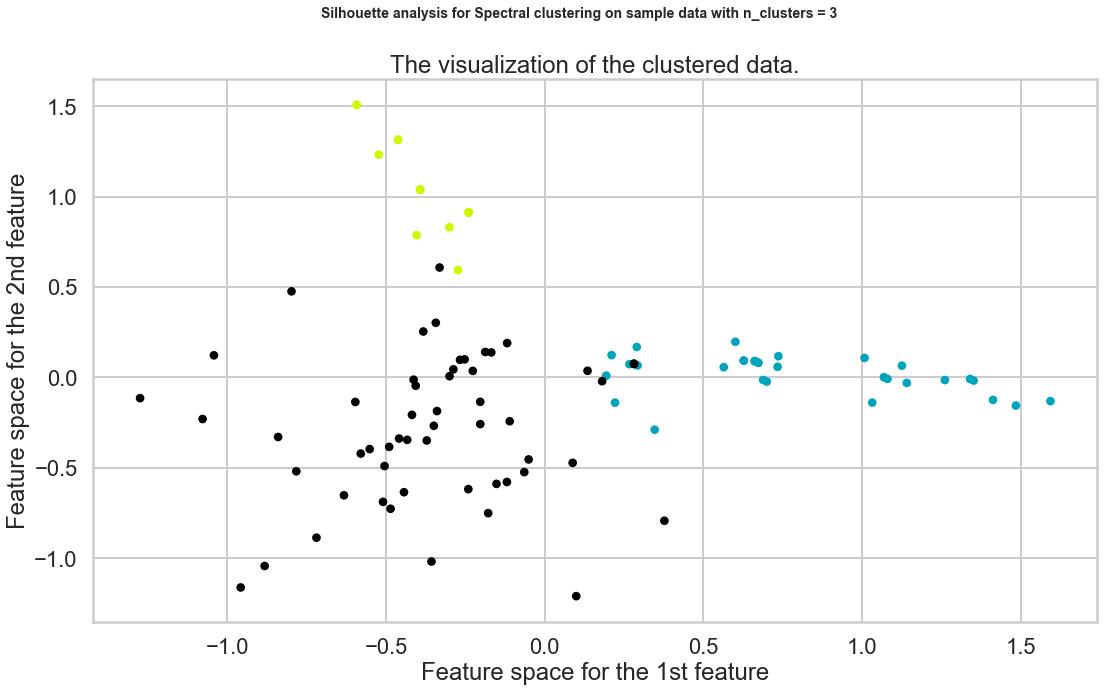

In [679]:
n_clusters = 3

fig,(ax1) = plt.subplots(1,1)
fig.set_size_inches(18,10)

colors = cm.nipy_spectral(reduced_data_sc.customer_cluster.astype(float) / n_clusters)

ax1.scatter(reduced_data_sc.x, reduced_data_sc.y, marker='.', lw=0,s=300, alpha=1,
                c=colors, edgecolor='k')
    
   
ax1.set_title("The visualization of the clustered data.")
ax1.set_xlabel("Feature space for the 1st feature")
ax1.set_ylabel("Feature space for the 2nd feature")

plt.suptitle(("Silhouette analysis for Spectral clustering on sample data "
              "with n_clusters = %d" % n_clusters),
                fontsize=14, fontweight='bold')

## Agglomerative clustering

In [680]:
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch

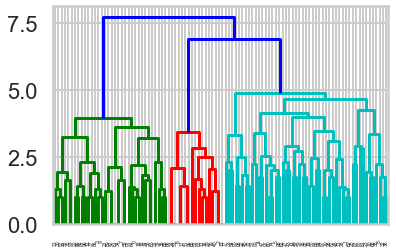

In [681]:
dendrogram = sch.dendrogram(sch.linkage(x_cols, method='ward'))

In [724]:
clustering_ac = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward').fit(x_cols)
set(clustering_ac.labels_)

{0, 1, 2}

In [738]:
labels_ac = clustering_ac.labels_
sil_coeff_ac = metrics.silhouette_score(x_cols,labels_ac,metric='euclidean')
print("Silhouette Coefficient: %0.3f"
      % sil_coeff_ac)

Silhouette Coefficient: 0.116


In [725]:
df_pivot_ac = df_pivot.drop('cluster',axis=1)
df_pivot_ac['cluster'] = clustering_ac.labels_
df_pivot_ac.head()


offer_id,customer_name,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,cluster
0,Adams,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,1
1,Allen,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
2,Anderson,0,0,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,0,0,2
3,Bailey,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,1
4,Baker,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0


In [726]:
reduced_data_ac = reduced_data.drop('customer_cluster',axis=1)
reduced_data_ac['customer_cluster'] = df_pivot_ac['cluster']
reduced_data_ac.head()

,x,y,customer_name,customer_cluster
0,1.007580,0.108215,Adams,1
1,-0.287539,0.044715,Allen,0
2,-0.392032,1.038391,Anderson,2
3,0.699477,-0.022542,Bailey,1
4,0.088183,-0.471695,Baker,0


Text(0.5, 0.98, 'Silhouette analysis for Spectral clustering on sample data with n_clusters = 3')

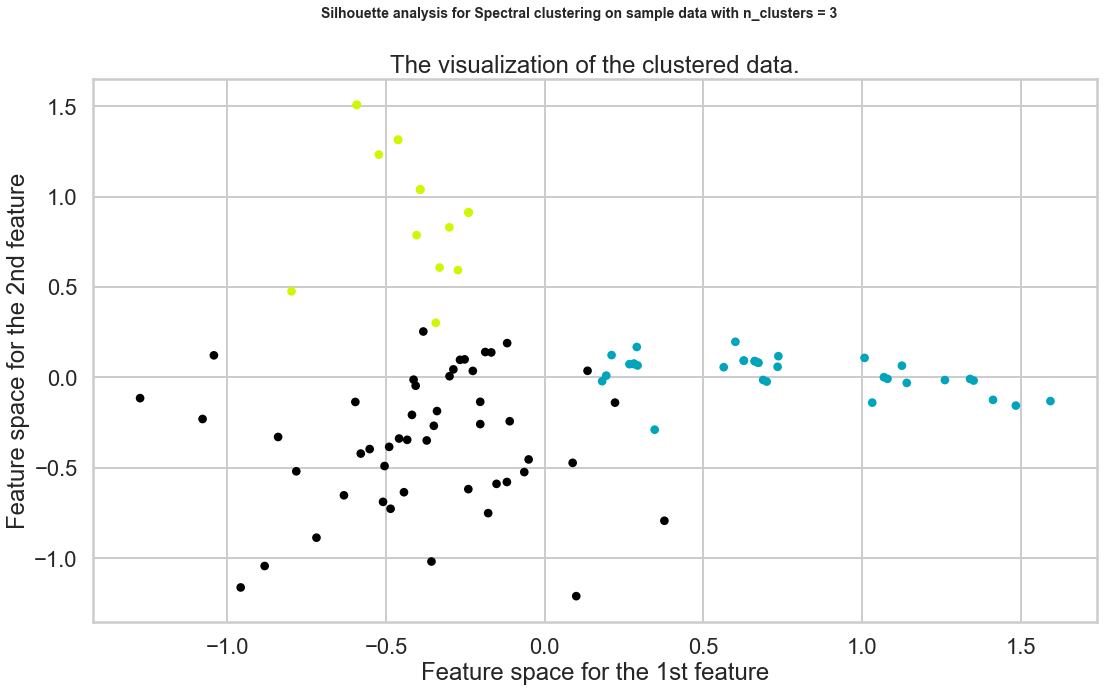

In [727]:
n_clusters = 3

fig,(ax1) = plt.subplots(1,1)
fig.set_size_inches(18,10)

colors = cm.nipy_spectral(reduced_data_ac.customer_cluster.astype(float) / n_clusters)

ax1.scatter(reduced_data_ac.x, reduced_data_ac.y, marker='.', lw=0,s=300, alpha=1,
                c=colors, edgecolor='k')
        
ax1.set_title("The visualization of the clustered data.")
ax1.set_xlabel("Feature space for the 1st feature")
ax1.set_ylabel("Feature space for the 2nd feature")

plt.suptitle(("Silhouette analysis for Spectral clustering on sample data "
              "with n_clusters = %d" % n_clusters),
                fontsize=14, fontweight='bold')

## DBSCAN clustering

In [728]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(x_cols)
clustering_db = DBSCAN(eps=1.4,min_samples=3).fit(x_cols)

In [729]:
labels_db = clustering_db.labels_
labels_db

array([ 0,  2,  1,  0, -1, -1,  1,  0, -1,  0, -1,  1,  0, -1, -1,  1, -1,
        1,  0, -1,  0,  0, -1, -1,  1, -1, -1, -1,  2, -1,  0, -1, -1, -1,
       -1,  3, -1,  0, -1,  3,  1,  1,  0, -1, -1, -1,  0, -1, -1, -1, -1,
       -1, -1,  1, -1,  0,  1,  0,  0, -1,  2,  0, -1,  0,  0, -1,  1, -1,
       -1,  2, -1,  2, -1,  0,  2,  0,  1, -1, -1,  1, -1, -1, -1,  1,  0,
        3,  0, -1, -1,  0, -1,  0, -1,  0, -1, -1,  0, -1, -1, -1],
      dtype=int64)

In [739]:
labels_db = clustering_db.labels_
sil_coeff_db = metrics.silhouette_score(x_cols,labels_db,metric='euclidean')
print("Silhouette Coefficient: %0.3f"
      % sil_coeff_db)

Silhouette Coefficient: 0.038


In [730]:
set(labels_db)

{-1, 0, 1, 2, 3}

In [731]:
df_pivot_db = df_pivot.drop('cluster',axis=1)
df_pivot_db['cluster'] = clustering_db.labels_
df_pivot_db.head()

offer_id,customer_name,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,cluster
0,Adams,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0
1,Allen,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,2
2,Anderson,0,0,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,0,0,1
3,Bailey,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
4,Baker,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,-1


In [732]:
reduced_data_db = reduced_data.drop('customer_cluster',axis=1)
reduced_data_db['customer_cluster'] = df_pivot_db['cluster']
reduced_data_db.head()

,x,y,customer_name,customer_cluster
0,1.007580,0.108215,Adams,0
1,-0.287539,0.044715,Allen,2
2,-0.392032,1.038391,Anderson,1
3,0.699477,-0.022542,Bailey,0
4,0.088183,-0.471695,Baker,-1


Text(0.5, 0.98, 'Silhouette analysis for Spectral clustering on sample data with n_clusters = 4')

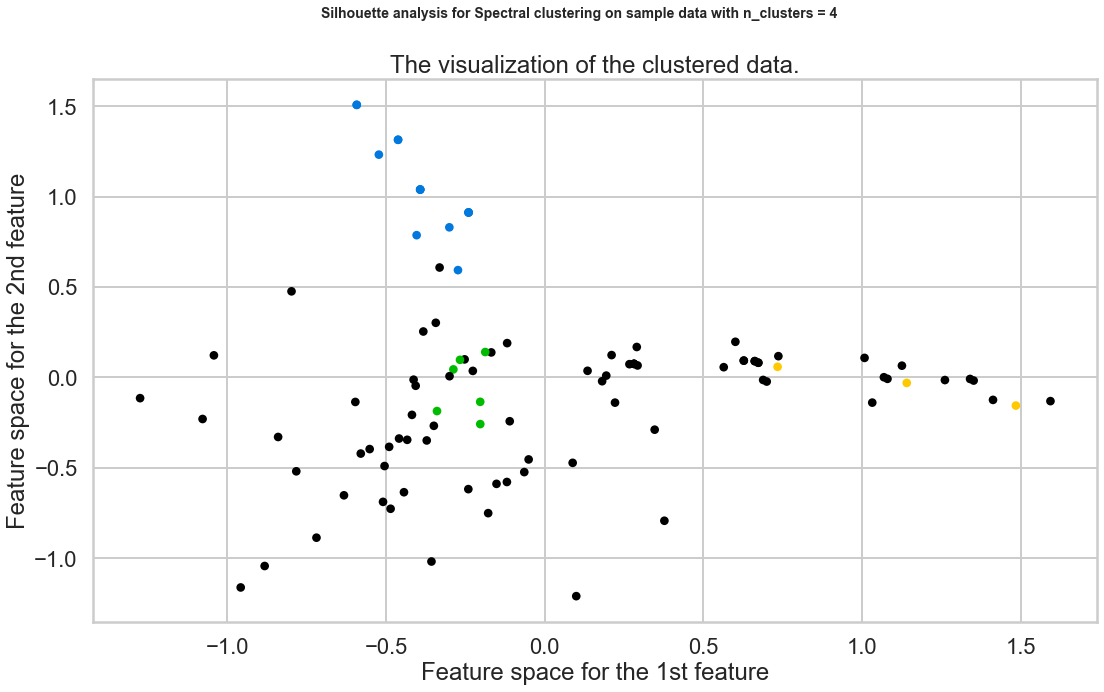

In [733]:
n_clusters = 4

fig,(ax1) = plt.subplots(1,1)
fig.set_size_inches(18,10)

colors = cm.nipy_spectral(reduced_data_db.customer_cluster.astype(float) / n_clusters)

ax1.scatter(reduced_data_db.x, reduced_data_db.y, marker='.', lw=0,s=300, alpha=1,
                c=colors, edgecolor='k')
    

#cluster_centers = pca.transform(clustering_sp.)

#ax1.scatter(cluster_centers[:, 0],cluster_centers[:, 1],marker='o',
#ax1.scatter(reduced_data.x, reduced_data.y,marker='o',
#            c="white", alpha=1,s=300, edgecolor='k')
    
#for i, c in enumerate(cluster_centers):
#        ax1.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,s=100, edgecolor='k')
    
ax1.set_title("The visualization of the clustered data.")
ax1.set_xlabel("Feature space for the 1st feature")
ax1.set_ylabel("Feature space for the 2nd feature")

plt.suptitle(("Silhouette analysis for Spectral clustering on sample data "
              "with n_clusters = %d" % n_clusters),
                fontsize=14, fontweight='bold')

## Comparison (based on cluster visualization)

- K-MEANS - Baseline mode with Silhouette Coff : 0.116
- Affinity Propagation - Has done well, but there are still few points seem to be miscalssified compared to K-MEANS. Silhouette Coff : 0.116
- Spectral Clustering - Seems to perform better that AP. But few points seem to be misclassified compared to K-MEANS. Silhouette Coff : 0.106
- Agglomerative Clustering - Works similar to K-MEANS.Silhouette Coff : 0.116
- DB - Seems to perform worst compared. May be I have not found the best epsilon and min samples yet. But I tried with many combinations. Silhouette Coff : 0.038

At the end, I would choose K-MEANS or AC